***
In this notebook i will be demonstarting Latent Dirichlet Allocation(LDA) for topic modelling. I will be using the Amazon fine food reviews dataset from Kaggle(https://www.kaggle.com/snap/amazon-fine-food-reviews) for performing LDA based topic modelling
I will be using the gensim package for LDA topic modelling and pyLDAvis for visualization of LDA topic model
***

In [3]:
!pip install pyLDAvis.genism

ERROR: Could not find a version that satisfies the requirement pyLDAvis.genism (from versions: none)
ERROR: No matching distribution found for pyLDAvis.genism


In [66]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import gensim
from gensim import corpora
# libraries for visualization
import pyLDAvis
#import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [33]:
review_data= pd.read_csv("/content/Reviews.csv")

In [34]:
review_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [36]:
#Lets Check out the data
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [37]:
"""
Function to clean text
"""
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [38]:
import nltk
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
# we will drop any null values
review_data.dropna(axis = 0, how ='any',inplace=True) 

In [41]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568411 non-null  int64 
 1   ProductId               568411 non-null  object
 2   UserId                  568411 non-null  object
 3   ProfileName             568411 non-null  object
 4   HelpfulnessNumerator    568411 non-null  int64 
 5   HelpfulnessDenominator  568411 non-null  int64 
 6   Score                   568411 non-null  int64 
 7   Time                    568411 non-null  int64 
 8   Summary                 568411 non-null  object
 9   Text                    568411 non-null  object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [42]:
# Now lets do basic cleaning on our data
review_data['Text'] = review_data['Text'].apply(clean_text)
#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


In [43]:
# Lets check the clean text
review_data['Text'][0]

'have bought several vitality canned food products have found them good quality product looks more like stew than processed meat smells better labrador finicky appreciates this product better than most'

In [44]:
# Creating a new column containg number of words in a review
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

In [45]:
review_data['Num_words_text']

0         30
1         20
2         52
3         22
4         17
          ..
568449    17
568450    26
568451    39
568452    21
568453     9
Name: Num_words_text, Length: 568411, dtype: int64

In [46]:
print("Rating and Freq")
print(review_data['Score'].value_counts())
print(len(review_data))
max_review_data_sentence_length  = review_data['Num_words_text'].max()

Rating and Freq
5    363111
4     80655
1     52264
3     42638
2     29743
Name: Score, dtype: int64
568411


In [47]:
# Now we will filter out reviews with more than 20 words and less than 100
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]

In [48]:
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)
print('No of Short reviews')
print(len(df_short_reviews))

No of Short reviews
373281


***
Let us pre-process the data
***

In [49]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)

In [54]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.2 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=67420c9eae18548a0545b8e2bcd2a8ff2af3f950d7522158f5e29f4cfd9aa0e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-qu4580xc/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [57]:
!pip3 install spacy
!python3 -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']):
  
  for sent in texts:
    doc = nlp(" ".join(sent)) 
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [ ]:

text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

***
Create vocabulary dictionary and document term matrix
***

In [63]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [65]:
lda_model.print_topics()

[(0,
  '0.031*"sauce" + 0.025*"good" + 0.024*"flavor" + 0.022*"bread" + 0.018*"chicken" + 0.016*"meat" + 0.012*"taste" + 0.012*"recipe" + 0.012*"flavorful" + 0.012*"cheese"'),
 (1,
  '0.033*"product" + 0.022*"weight" + 0.016*"pasta" + 0.015*"thank" + 0.014*"hair" + 0.013*"benefit" + 0.010*"time" + 0.010*"coconut" + 0.009*"home" + 0.008*"color"'),
 (2,
  '0.069*"food" + 0.035*"treat" + 0.020*"time" + 0.020*"dog" + 0.017*"love" + 0.015*"year" + 0.015*"good" + 0.014*"product" + 0.014*"cat" + 0.013*"great"'),
 (3,
  '0.153*"coffee" + 0.029*"good" + 0.028*"strong" + 0.027*"flavor" + 0.019*"blend" + 0.019*"bean" + 0.016*"morning" + 0.014*"great" + 0.014*"taste" + 0.013*"kcup"'),
 (4,
  '0.028*"cereal" + 0.027*"candy" + 0.027*"time" + 0.012*"ginger" + 0.012*"lunch" + 0.012*"pepper" + 0.011*"year" + 0.011*"great" + 0.010*"easy" + 0.010*"long"'),
 (5,
  '0.067*"store" + 0.056*"product" + 0.054*"price" + 0.034*"order" + 0.030*"great" + 0.029*"local" + 0.025*"good" + 0.023*"grocery" + 0.019*"ship

In [71]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.137113  0.026504       1        1  16.290431
2      0.045314 -0.111506       2        1  14.441102
6     -0.170405  0.049673       3        1  14.008811
5     -0.016075 -0.235050       4        1  10.306822
3     -0.140673  0.040757       5        1  10.030376
8     -0.105303 -0.138884       6        1   9.575804
0     -0.101653  0.268976       7        1   6.844762
4      0.188631  0.002548       8        1   6.567445
7      0.274943  0.138532       9        1   6.255843
1      0.162334 -0.041551      10        1   5.678604, topic_info=        Term          Freq         Total Category  logprob  loglift
3     coffee  28457.000000  28457.000000  Default  30.0000  30.0000
30      food  21843.000000  21843.000000  Default  29.0000  29.0000
136    store  12846.000000  12846.000000  Default  28.0000  28.0000
84    flavor  29925.000000  29925.000000  Default  27.0000  27.0000
90   product  26614.000000  26614.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
213  several    601.767395   3734.680624  Topic10  -5.1636   1.0429
219    great    693.531026  30003.447693  Topic10  -5.0216  -0.8988
21     water    624.356952   9161.080669  Topic10  -5.1267   0.1825
352   health    545.707203   2384.720131  Topic10  -5.2614   1.3937
667    light    548.532900   3488.848415  Topic10  -5.2562   1.0184

[551 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
490       1  0.179583   able
490       3  0.081957   able
490       4  0.338375   able
490       5  0.014463   able
490       8  0.291973   able
...     ...       ...    ...
340       5  0.048563   year
340       7  0.018388   year
340       8  0.128716   year
1527      4  0.997551  yeast
980       6  0.999034  yummy

[842 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 7, 6, 4, 9, 1, 5, 8, 2])

In [ ]:
# Now to check our LDA's perfromance we will use Perplexity and Coherence score

In [72]:
# Perplexity (lower = Better)
print('Perplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000)) 
# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.68064946799338

Coherence Score:  0.4114099442951563



Method to find optimal number of topics
Code from:https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

In [73]:


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [74]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

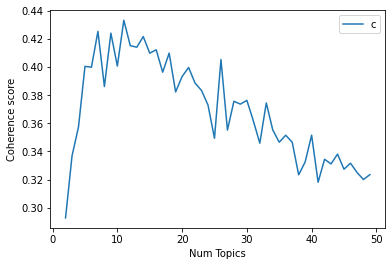

In [75]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [76]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2927
Num Topics = 3  has Coherence Value of 0.3367
Num Topics = 4  has Coherence Value of 0.3574
Num Topics = 5  has Coherence Value of 0.4004
Num Topics = 6  has Coherence Value of 0.3998
Num Topics = 7  has Coherence Value of 0.4253
Num Topics = 8  has Coherence Value of 0.3861
Num Topics = 9  has Coherence Value of 0.424
Num Topics = 10  has Coherence Value of 0.4006
Num Topics = 11  has Coherence Value of 0.4332
Num Topics = 12  has Coherence Value of 0.4151
Num Topics = 13  has Coherence Value of 0.414
Num Topics = 14  has Coherence Value of 0.4216
Num Topics = 15  has Coherence Value of 0.4098
Num Topics = 16  has Coherence Value of 0.4122
Num Topics = 17  has Coherence Value of 0.3963
Num Topics = 18  has Coherence Value of 0.4098
Num Topics = 19  has Coherence Value of 0.3822
Num Topics = 20  has Coherence Value of 0.3932
Num Topics = 21  has Coherence Value of 0.3996
Num Topics = 22  has Coherence Value of 0.3885
Num Topics = 23  has Co

In [77]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.066*"chip" + 0.022*"good" + 0.019*"potato" + 0.018*"bag" + 0.015*"snack" + 0.014*"great" + 0.012*"month" + 0.011*"fresh" + 0.010*"time" + 0.010*"year"'),
 (1,
  '0.044*"store" + 0.041*"price" + 0.031*"product" + 0.026*"great" + 0.025*"good" + 0.022*"cookie" + 0.019*"local" + 0.018*"order" + 0.016*"grocery" + 0.013*"time"'),
 (2,
  '0.133*"coffee" + 0.027*"good" + 0.019*"strong" + 0.018*"flavor" + 0.016*"blend" + 0.016*"taste" + 0.016*"bean" + 0.015*"great" + 0.011*"bold" + 0.011*"kcup"'),
 (3,
  '0.039*"product" + 0.039*"sugar" + 0.022*"free" + 0.020*"shipping" + 0.016*"good" + 0.013*"ingredient" + 0.011*"great" + 0.011*"natural" + 0.011*"syrup" + 0.011*"bottle"'),
 (4,
  '0.103*"food" + 0.023*"good" + 0.018*"cat" + 0.018*"sauce" + 0.014*"meal" + 0.013*"chicken" + 0.011*"healthy" + 0.011*"ingredient" + 0.010*"baby" + 0.010*"rice"'),
 (5,
  '0.023*"salt" + 0.022*"good" + 0.019*"flavor" + 0.019*"butter" + 0.018*"great" + 0.016*"snack" + 0.016*"little" + 0.015*"cereal" + 0.015*"

In [79]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.137113  0.026504       1        1  16.287059
2      0.045314 -0.111506       2        1  14.447668
6     -0.170405  0.049673       3        1  14.009822
5     -0.016075 -0.235050       4        1  10.308228
3     -0.140673  0.040757       5        1  10.030490
8     -0.105303 -0.138884       6        1   9.573752
0     -0.101653  0.268976       7        1   6.844516
4      0.188631  0.002548       8        1   6.564897
7      0.274943  0.138532       9        1   6.255492
1      0.162334 -0.041551      10        1   5.678077, topic_info=        Term          Freq         Total Category  logprob  loglift
3     coffee  28457.000000  28457.000000  Default  30.0000  30.0000
30      food  21851.000000  21851.000000  Default  29.0000  29.0000
136    store  12848.000000  12848.000000  Default  28.0000  28.0000
84    flavor  29922.000000  29922.000000  Default  27.0000  27.0000
90   product  26616.000000  26616.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
213  several    601.711508   3734.368067  Topic10  -5.1636   1.0430
219    great    693.466618  30003.147245  Topic10  -5.0216  -0.8988
21     water    624.298968   9161.606994  Topic10  -5.1267   0.1824
352   health    545.656523   2384.816260  Topic10  -5.2614   1.3937
667    light    548.481958   3488.507744  Topic10  -5.2562   1.0185

[551 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
490       1  0.179602   able
490       3  0.081966   able
490       4  0.338411   able
490       5  0.014465   able
490       8  0.291703   able
...     ...       ...    ...
340       5  0.048557   year
340       7  0.018386   year
340       8  0.128604   year
1527      4  0.997415  yeast
980       6  0.999248  yummy

[842 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 7, 6, 4, 9, 1, 5, 8, 2])